# OSMUtils Examples

When developing, to test newly saved code:

- restart kernel
- after each save in the command line use: `!pip install -e .` to install osmUtils from local directory
- if this imports with no issues, the code it good!
- then re-import osmUtils


In [1]:
!pip install -e .

from IPython.display import clear_output
clear_output()

import osmUtils as osmu
from osmUtils import utils_geo, utils_osm

print(f'osmUtils ver. {osmu.__version__} ready!')

osmUtils ver. 0.0.1 ready!


#### ### Instantiate osmCol Object

In [2]:
import LMIPy as lmi #Docs https://lmipy.readthedocs.io/en/latest/quickstart.html#From-Political-Boundaries

params={
    'iso': 'USA',
    'adm1': 33,
    'adm2': 32
}

ny_geom = lmi.Geometry(parameters=params)
ny_geom.map()

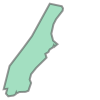

In [3]:
geom = ny_geom.shape()[0].buffer(0)
geom

In [4]:
col = osmu.CollectionOsm(geometry=geom, zoom=5, crs=None, geom_tiles=False)

/Users/vizzuality/Workspace/vizzTools/osmUtils/osmUtils/utils_geo.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manifest['exclude'] = 0
/Users/vizzuality/Workspace/vizzTools/osmUtils/osmUtils/utils_geo.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manifest['exported'] = 0
/Users/vizzuality/Workspace/vizzTools/osmUtils/osmUtils/utils_geo.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [5]:
col.crs

'EPSG:4326'

In [7]:
col.geometry_gdf

,geometry,0
0,"POLYGON ((-73.98656 40.79379, -73.96997 40.816...","POLYGON ((-73.98656 40.79379, -73.96997 40.816..."


Notes - THe library will contain a collectionOsm.py for the generation of the manifest and a objectOsm.py to run the individual tiles/geometries from the manifest.

Append here the image.

Link to info for getters and setters in python: https://stackoverflow.com/questions/2627002/whats-the-pythonic-way-to-use-getters-and-setters

# Library Development

### Example of how to set setters and getters - pro

In [ ]:
class C(object):
    def __init__(self):
        self._x = None

    @property
    def x(self):
        """I'm the 'x' property."""
        print("getter of x called")
        return self._x

    @x.setter
    def x(self, value):
        print("setter of x called")
        self._x = value

    @x.deleter
    def x(self):
        print("deleter of x called")
        del self._x

In [ ]:
C.x = 'elena'

In [ ]:
del C.x

## Example clean OSM pipeline

In [ ]:
# import libraries
import requests
import geopandas as gpd
import shapely.wkb

In [ ]:
queryUrl = 'https://api.resourcewatch.org/v1/query/Politcial-Boundaries-GADM-adminitrative-level-1-1490086842541'
#queryParams = {'sql': "select the_geom, name_1 from gadm28_adm1 where iso='USA'"}
queryParams = {'sql': "select * from gadm28_adm1 where name_1='New York'"}
resp = requests.get(queryUrl, queryParams)

In [ ]:
for el in data:
    geometry =  shapely.wkb.loads(el['the_geom'], hex=True)
    name = el['name_1']
    el['geometry']=geometry

In [ ]:
gdf = gpd.GeoDataFrame(data)
gdf.head()

## Validate incomming geometry and tiles for manifest:

In [ ]:
#WE'RE GOING TO WORK WITH THE GEOMETRY OF THE ESTATE OF NEW YORK 
geometry = gdf['geometry'][0]
geometry.

In [ ]:
geometry.to_wkt()

In [ ]:
gdf['geojson'].iloc[0]

## LIB:

In [ ]:
geometry_df = gpd.GeoDataFrame(geometry)

In [ ]:
geometry_df = geometry_df.set_geometry(0)
geometry_df = geometry_df.rename(columns={0:'geometry'})
geometry_df.head()

In [ ]:
#import libraries for the generation of the manifest
import mercantile as mt
from shapely.geometry import shape
import pandas as pd

In [ ]:
zoom_levels = 6

In [ ]:
## Create tiles df
tiles = []
for tile in mt.tiles(-180, -85, 180, 85, zoom_levels, truncate=False):
    
    tile_id = f"{tile.z}_{tile.x}_{tile.y}"
    
    geom = mt.feature(tile)['geometry']
    polygon = shape(geom)
    
    tiles.append({
        'tile_id': tile_id,
        'geometry': polygon
    })
    
# generate geodataframe with tiles
tiles_df = gpd.GeoDataFrame(tiles)

len(f'There are {tiles_df} tiles originally')


In [ ]:
#check  projection tiles and geometry

default_crs = "EPSG:4326"
if geometry_df.crs is None:
    #set crs
    geometry_df = geometry_df.set_crs(default_crs)
    
    
#check projection of tiles
if tiles_df.crs is None:
    tiles_df = tiles_df.set_crs(default_crs)
    

In [ ]:
# keep tiles that intersect with input geometry
# Spatial join land and tiles, then remove rows without intersect

geom_tiles = gpd.sjoin(tiles_df, geometry_df, how='left', op='intersects',  lsuffix='tiles', rsuffix='geom')

## Keep only intersecting tile geoms
manifest = geom_tiles[pd.notna(geom_tiles.geometry_geom)]
#add the tracking information
manifest['exclude'] = 0
manifest['exported'] = 0
manifest['uploaded'] = 0

manifest.head()

## Work in the lib:

In [ ]:
import mercantile as mt
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, MultiPolygon, Polygon

In [ ]:
#class OsmCollection(object):
#    def __init__(self, geometry=None, zoom=[5,7], **kwargs):
#        self.geometry = geometry
#        self.min_zoom, self.max_zoom = sorted(zoom)
#        self.tiles = self.generate_tiles()
#        ### Methods
#        def generate_tiles(self):
#            """Generates tiles and ids"""
#            return gdf
#        def stage_requests(self, osm_request_config)
#        """
#        - Iterate through self.tiles
#        - optionally is_intersect? operation to remove unneeded tiles
#        - intatiate OsmObj class fro each row in self.tiles
#        """
#        ## obj = OsmObj(geom, tile, osm_request_config)
#        self.something = "List of OsmObj objects"
        
class CollectionOsm:
    """
    This is the main CollectionOsm class. This collection class will produce a tile manifest at an especific zoom level
     to keep track of the OSM retrieving process.

    Parameters
    ----------
    geometry: shapely.geometry.Polygon or shapely.geometry.MultiPolygon
        geographic boundaries to fetch geometries within
    zoom: int
        zoom levels to generate the tiles
    crs: str
        the starting CRS of the passed-in geometry. if None, it will be set to "EPSG:4326"
    manifest_geom: str
        geometry to be mantained in the manifest. 'tile' will mantain the tile geoms in the manifest
        while 'geom' will mantain the original geom.

    """
    def __init__(self, geometry=None, zoom=5, crs=None, tile_geom=True, **kwargs):
        
        self.zoom = zoom
        if crs is None:
            self.crs = default_crs
        else:
            self.crs = crs
        self.tiles = None
        
        #generate geometry gdf
        self.geometry = self.geometry_to_gdf(geometry=geometry, crs=self.crs)
        
        if tile_geom:
            self.tiles = self.generate_tiles(crs=self.crs)
            
        #generate manifest
        self.manifest = self.generate_manifest(geometry=self.geometry, tiles=self.tiles)
        
            
        #else:
        #    #generate manifest for inserted geom
        #    print('todo')
            
    #def __repr__(self):
    #    return 'yes'
    #
        #methods
        
    def generate_tiles(self, crs):
        """
        Generate tiles for the manifest.
        """

        #generate tiles
        tiles = []
        for tile in mt.tiles(-180, -85, 180, 85, self.zoom, truncate=False):

            tile_id = f"{tile.z}_{tile.x}_{tile.y}"

            geom = mt.feature(tile)['geometry']
            polygon = shape(geom)

            tiles.append({
                'tile_id': tile_id,
                'geometry': polygon
            })

        # generate geodataframe with tiles
        gdf = gpd.GeoDataFrame(tiles)
        
        #check projection 
        if gdf.crs is None:
            gdf = self.set_crs(gdf, crs)

        elif gdf.crs != self.crs:
            gdf = self.reproject_gdf(gdf,crs)
        return gdf
    
    def geometry_to_gdf(self,geometry, crs):
        """
        Create GeoDataFrame from a (multi)polygon.
        Parameters
        ----------
        geometry : shapely.geometry.Polygon or shapely.geometry.MultiPolygon
            geographic boundaries to fetch geometries within
        Returns
        -------
        gdf : geopandas.GeoDataFrame
        """
        #check that incomming geometry is valid
        if not geometry.is_valid:
            print('The geometry is invalid')
        #check that the geometry is a polygon or multipolygon
        if not isinstance(geometry, (Polygon, MultiPolygon)):
            print('The geometry must be a shapely.geometry.Polygon or shapely.geometry.MultiPolygon')
    
        #create gdf from the incomming geometry

        gdf = gpd.GeoDataFrame(geometry)
        gdf = gdf.set_geometry(0)
        gdf = gdf.rename(columns={0:'geometry'})

        if gdf.crs is None:
            gdf = self.set_crs(gdf, crs)

        elif gdf.crs != self.crs:
            gdf = self.reproject_gdf(gdf,crs)

        return gdf

    def set_crs(self, gdf, crs):
        """
        Set CRS in GeoDataFrame when current projection is not defined.
        Parameters
        ----------
        gdf : geopandas.GeoDataFrame
            the geodataframe to set the projection
        Returns
        -------
        gdf : geopandas.GeoDataFrame
            the geodataframe with the projection defined """
        gdf = gdf.set_crs(crs)
        
        return gdf

    def reproject_gdf(self, gdf,to_crs):
        """Project a GeoDataFrame from its current CRS to another.
        Parameters
        ----------
        gdf : geopandas.GeoDataFrame
            the GeoDataFrame to be projected
        to_crs : string 
            CRS to project the geodataframe
        Returns
        ----------
        gdf_proj : geopandas.GeoDataFrame
            the projected GeoDataFrame"""

        gdf_proj = gdf.to_crs(epsg=to_crs)
        return gdf_proj
    
    def generate_manifest(self, geometry, tiles):
    
        """Generates a gedodataframe manifest to keep track of the osm retrieving process.
            Parameters
            ----------
            geometry : geopandas.GeoDataFrame
                the GeoDataFrame to be projected
            tiles : geopandas.GeoDataFrame 
                tiles geodataframe to be intersected with the incomming geometry.
                if None, it will produce a manifest just for the incomming geometry.
            Returns
            ----------
            manifest : geopandas.GeoDataFrame
                manifest geodataframe"""


        if tiles is None:
            #return manifest for geometry
            geom_tiles = geometry
        else:
            geom_tiles = gpd.sjoin(tiles, geometry, how='left', op='intersects',  lsuffix='tiles', rsuffix='geom')

        ## Keep only intersecting tile geoms
        manifest = geom_tiles[pd.notna(geom_tiles.geometry_geom)]
        #add the tracking information
        manifest['exclude'] = 0
        manifest['exported'] = 0
        manifest['uploaded'] = 0

        return manifest

In [ ]:
osm_col = CollectionOsm(
    geometry=geometry,
    zoom=6,
    crs='EPSG:4326',
    tile_geom=True)
osm_col

In [ ]:
osm_col.manifest